In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Supress TF nuisance error messages for final run
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from keras.utils import text_dataset_from_directory

# Problem
Twitter (now X) is an active and real time communication device. When a user witnesses a disaster first hand and immediately posts about their experience, that can someitmes be the very first report of the event. When responding to disasters, timeliness is often the most critical component and therefore these posts might serve as a valuable early warning system for disaster response agencies. 
The problem arises from the limited reach of most of these posts. An automated system could search new posts for evidence of a disaster ongoing, but the automated system would not reliably know the difference between colorful language and an actual disaster. Consider the following examples:
    
    'This band is fire, playing on the roof of my apartment! I am on Twitter when I should probably be dancing up there.'
    
    'There is a fire on the third floor of my apartment! I am on Twitter when I should probably be getting out of here.'
    
The only disaster in the first post might be the poster's dancing, but the second post is an early report of an extremely dangerous situation and live information from someone still in the building. 

For this project we are going to program a recurrent neural network to attempt to learn the context of the language chosen well enough to determine which posts are reports of a real disaster (1) and which posts are not (0)

To set up this rnn, I adapted the keras tutorial on rnn networks.  

https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://www.tensorflow.org/tutorials/load_data/text


# Data
The data are provided from the kaggle competition, Natural Language Processing with Disaster Tweets, https://www.kaggle.com/c/nlp-getting-started/overview. The data is in a train.csv file and a test set in test.csv. The training data has handmarked labels provided for each of the posts as well as some meta data on some of the posts including location and a keyword which was initially used to flag the posts as potential "disaster tweets"


In [2]:
with open('train.csv') as f:
    train_df = pd.read_csv(f)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### There are 7613 tweets of various lengths and variety of topics. Some of them are about disasters or other emergencies and the others are about anything else. 

In [4]:
train_df.sample(10)

,id,keyword,location,text,target
4917,7002,mayhem,"Raleigh, NC",I liked a @YouTube video from @itsjustinstuart...,1
4355,6187,hijacker,San Francisco,Governor allows parole for California school b...,1
7098,10171,violent%20storm,NaN,#Amsterdam POV video captures violent landing ...,1
5173,7378,obliterate,NaN,Wondering if gold could gap up $50 on the jobs...,0
2764,3970,devastation,"Victoria, British Columbia",@Pam_Palmater i agree with @perrybellegarde to...,1
6237,8906,snowstorm,"Louisiana, USA",you're the snowstorm I'm purified. the darkest...,0
968,1401,body%20bag,NaN,Check out Vintage Longaberger Floral Fabric Sh...,0
6498,9290,sunk,NaN,The Seven Seas - Wreck of the Giannis D. sunk ...,1
4683,6658,landslide,"Dundee, UK",Army veteran fears loose rocks from Dundee lan...,1
6719,9625,thunderstorm,East Coast,THE NATIONAL WEATHER SERVICE IN LITTLE ROCK HA...,1


# Cleaning

Cleaning this data is primarly about putting it into a format that the Keras module prefers for loading datasets. I have also chosen to proceed without the other metadata keywords added in the set and the location. The keywords should get picke dup by the model if they are relevant and location can't be relevant to disasters since they can happen anywhere. 

## Convert data to keras preferred format
Keras text_dataset_from_directory method requires text to be in separate files and sorted in labelled folders

In [5]:
# Keeping only the tweets, labels and id from the posts

tweets = train_df['text'].values
labels = train_df['target'].values
ids = train_df['id'].values

In [6]:
for id, tweet, label in zip(ids, tweets,labels):
    with open(f'train/{label}/{id}.txt', 'w') as f:
        f.write(tweet)

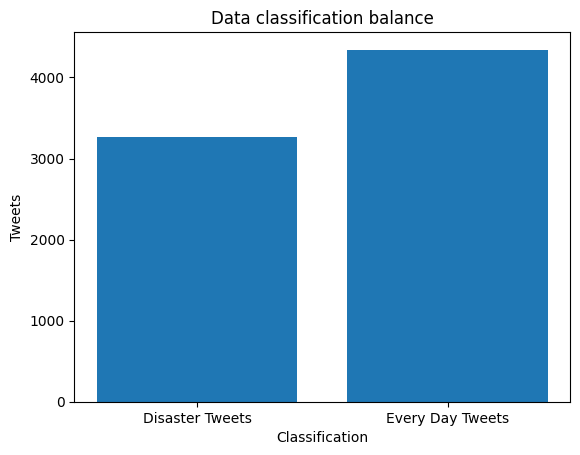

In [7]:
every_day_tweets = len(os.listdir('train/0'))
disaster_tweets = len(os.listdir('train/1'))

labels = ['Disaster Tweets', 'Every Day Tweets']
values = [disaster_tweets, every_day_tweets]

# Create the bar plot
plt.bar(labels, values)

# Set the title and labels for the axes
plt.title('Data classification balance')
plt.xlabel('Classification')
plt.ylabel('Tweets')

# Display the histogram
plt.show()

### Convert the test data to individual files as well

In [8]:
# Write each of the test tweets to inividual files

with open('test.csv') as f:
    test_df = pd.read_csv(f)
tweets = test_df['text'].values
ids = test_df['id'].values
for id, tweet in zip(ids, tweets):
    with open(f'test/{id}.txt', 'w') as f:
        f.write(tweet)

# Load Data Sets

In [9]:
# Keras loads the data and splits it into an 80% training set and 20% validation set (as set in the below parameters) 

train_ds, valid_ds = text_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=None,
    max_length=None,
    shuffle=True,
    seed=43,
    validation_split=0.2,
    subset='both',
    follow_links=False
)

Found 7613 files belonging to 2 classes.
Using 6091 files for training.
Using 1522 files for validation.


In [10]:
# One of the early problems was getting the shape of the data correct
train_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [11]:
valid_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [12]:
# Example of one data point in the new format
for example, label in train_ds.take(1):
  print('Tweet: ', example.numpy())
  print('Label: ', label.numpy())

Tweet:  b"I know it's a question of interpretation but this is a sign of the apocalypse.  I called it https://t.co/my8q1uWIjn"
Label:  1


In [13]:
# Also load the Test data as a dataset
test_ds = text_dataset_from_directory('test', labels=None)

Found 3263 files belonging to 1 classes.


In [14]:
# Alogrithm optimization methods to preload as much data as possible to speed up run-time
buffer_size = 10000
batch_size = 64
train_ds = train_ds.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# Data has now changed into a data set of batches 
train_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [16]:
valid_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Now the dataset is in batches so take(1) pulls a list of tweets instead of only 1 

In [17]:
# sample data is now a list so I print just three from the list. 
for example, label in train_ds.take(1):
  print('Tweets: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

Tweets:  [b'I love fruits'
 b'1 hour parade like 50 people collapsed. #OneHeartOneMindOneCSS'
 b'AMBULANCE SPRINTER AUTOMATIC FRONTLINE VEHICLE CHOICE OF 14 LEZ COMPLIANT | eBay http://t.co/4evTTqPEia']

labels:  [0 1 0]


In [18]:
for example, label in valid_ds.take(1):
  print('Tweets: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

Tweets:  [b'2 Burning Man Tickets + Vehicle Pass - Full read by eBay http://t.co/b0eS3ZIORK http://t.co/juIIt2YFVo'
 b'4 Printable Emergency Plan Templates\nhttp://t.co/nAex0Q1Ax0'
 b'Ogun smugglers engage Customs in shootout\xc3\xa5\xc3\x8a: Several persons were allegedly injured on Wednesday when men o... http://t.co/pUXBC2LoYK #RT']

labels:  [0 0 1]


# Text encoding

The RNN operator off of the data as numbers so it needs to be encoded in order to set the weights. The TextVectorization layer built into Keras is quite complex, built of a number of sub layers. 
1. It breaks the words into tokens. 
2. It counts the most common tokens to build a vocabulary up to the size granted with the VOCAB_SIZE parameter
3. The vocabulary words are assigned an integer value. This stands in as an identifier for the word.
4. The input text is converted to vector of these integers. Replacing the English sentences with these lists of numbers.

In [19]:
VOCAB_SIZE = 3000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'in', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'with', 'it', 'that', 'by', 'at', 'this'],
      dtype='<U19')

# Build the Model

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Model Training

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

In [25]:
history = model.fit(train_ds, epochs=10,
                    validation_data=valid_ds,
                   callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1708477817.018353   82577 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 [==============================] - 17s 116ms/step - loss: 0.6900 - accuracy: 0.5569 - val_loss: 0.6845 - val_accuracy: 0.5716
Epoch 2/10
96/96 [==============================] - 7s 69ms/step - loss: 0.6683 - accuracy: 0.5861 - val_loss: 0.6363 - val_accuracy: 0.6439
Epoch 3/10
96/96 [==============================] - 5s 52ms/step - loss: 0.5537 - accuracy: 0.7669 - val_loss: 0.5243 - val_accuracy: 0.7589
Epoch 4/10
96/96 [==============================] - 5s 48ms/step - loss: 0.4356 - accuracy: 0.8217 - val_loss: 0.5022 - val_accuracy: 0.7786
Epoch 5/10
96/96 [==============================] - 5s 47ms/step - loss: 0.3818 - accuracy: 0.8516 - val_loss: 0.4850 - val_accuracy: 0.7852
Epoch 6/10
96/96 [==============================] - 4s 45ms/step - loss: 0.3431 - accuracy: 0.8690 - val_loss: 0.5070 - val_accuracy: 0.7825
Epoch 7/10
96/96 [==============================] - 4s 42ms/step - loss: 0.3144 - accuracy: 0.8823 - val_loss: 0.5208 - val_accuracy: 0.7884
Epoch 8/10
96/96 [====

In [26]:
valid_loss, valid_acc = model.evaluate(valid_ds)

print('Validation Loss:', valid_loss)
print('Validation Accuracy:', valid_acc)

24/24 [==============================] - 0s 20ms/step - loss: 0.4850 - accuracy: 0.7852
Validation Loss: 0.48498791456222534
Validation Accuracy: 0.7851511240005493


In [27]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7099895000457763)

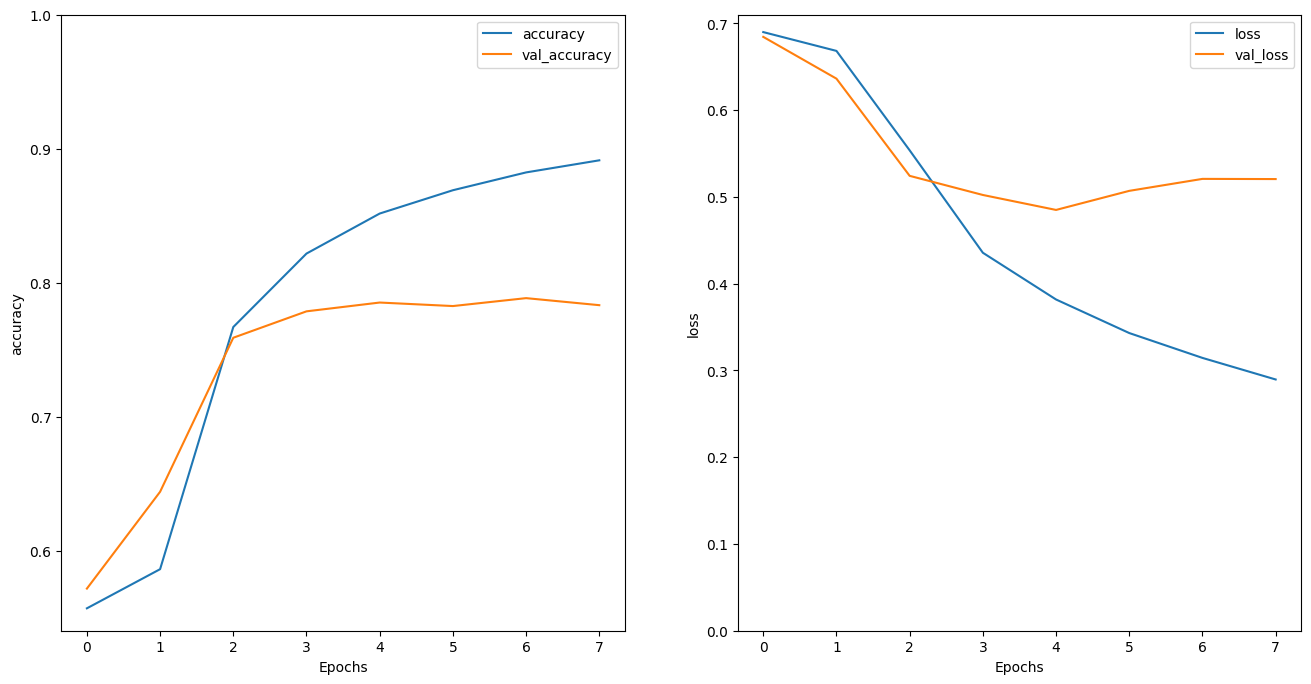

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Model Tuning

The first attempt immediately reached maximum validity after the first two epochs so several items were added so reduce overfitting. 
1. Another LSTM layer was added to increase the recurrent nature of the model.
2. A 50% drop out layer was added
3. Activation of the final layer was changed to sigmoid in order to allow the binary classification of the outputs. 

In [33]:
model_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
history = model_2.fit(train_ds, epochs=10,
                    validation_data=valid_ds,
                    callbacks=[early_stopping])

Epoch 1/10
96/96 [==============================] - 23s 141ms/step - loss: 0.6881 - accuracy: 0.5687 - val_loss: 0.6799 - val_accuracy: 0.5716
Epoch 2/10
96/96 [==============================] - 9s 90ms/step - loss: 0.6584 - accuracy: 0.6142 - val_loss: 0.6216 - val_accuracy: 0.7102
Epoch 3/10
96/96 [==============================] - 8s 83ms/step - loss: 0.5355 - accuracy: 0.7861 - val_loss: 0.5258 - val_accuracy: 0.7602
Epoch 4/10
96/96 [==============================] - 8s 83ms/step - loss: 0.4247 - accuracy: 0.8371 - val_loss: 0.5075 - val_accuracy: 0.7806
Epoch 5/10
96/96 [==============================] - 7s 76ms/step - loss: 0.3693 - accuracy: 0.8572 - val_loss: 0.5042 - val_accuracy: 0.7858
Epoch 6/10
96/96 [==============================] - 7s 77ms/step - loss: 0.3311 - accuracy: 0.8754 - val_loss: 0.5138 - val_accuracy: 0.7943
Epoch 7/10
96/96 [==============================] - 7s 76ms/step - loss: 0.3023 - accuracy: 0.8928 - val_loss: 0.5430 - val_accuracy: 0.7825
Epoch 8/10


In [36]:
valid_loss, valid_acc = model_2.evaluate(valid_ds)

print('Validation Loss:', valid_loss)
print('Validation Accuracy:', valid_acc)

24/24 [==============================] - 1s 33ms/step - loss: 0.5042 - accuracy: 0.7858
Validation Loss: 0.5042150616645813
Validation Accuracy: 0.7858081459999084


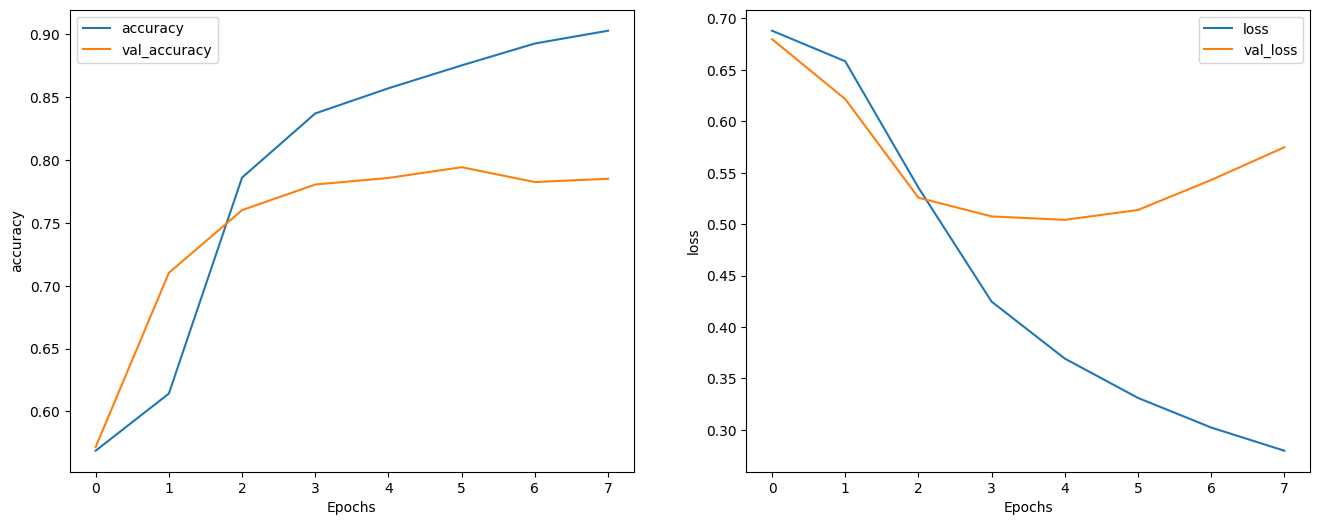

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Manually checking results of the model

### Everyday Tweets

In [81]:
sample_text = ('I love pie!')
round(model_2.predict([sample_text])[0,0])

1/1 [==============================] - 0s 63ms/step


0

In [82]:
sample_text = ('This tweet is not about a real disaster')
round(model_2.predict([sample_text])[0,0])

1/1 [==============================] - 0s 63ms/step


0

### Clear cut Disasters

In [83]:
sample_text = ('This tweet is about a real disaster')
round(model_2.predict([sample_text])[0,0])

1/1 [==============================] - 0s 58ms/step


0

In [84]:
sample_text = ('There is a fire on the third floor of my apartment!'
               'I am on Twitter when I should probably be getting out of here.')
round(model_2.predict([sample_text])[0,0])

1/1 [==============================] - 0s 63ms/step


0

In [85]:
sample_text = ('Just happened a terrible car crash')
round(model_2.predict([sample_text])[0,0])

1/1 [==============================] - 0s 68ms/step


1

### Very Context specific

In [86]:
sample_text = ('This band is fire, playing on the roof of my apartment!  '
               'I am on Twitter when I should probably be dancing up here.')
round(model_2.predict([sample_text])[0,0])

1/1 [==============================] - 0s 58ms/step


0

In [87]:
sample_text = ('FIRE!')
round(model_2.predict([sample_text])[0,0])

1/1 [==============================] - 0s 60ms/step


1

# Create the test predictions for the Kaggle Competition

In [44]:
with open('test.csv') as f:
    test_df = pd.read_csv(f)
ids = test_df['id']

In [45]:
# Make predictions using the trained model
predictions = model.predict(test_ds)

102/102 [==============================] - 2s 19ms/step


In [46]:
predicted_classes = np.ravel(predictions >= 0.5).astype(int)

In [47]:
results = pd.DataFrame({'id': ids, 'target': predicted_classes})
results.to_csv('test_predictions.csv', index=False)

# Conclusion

The model ended up with an 80% accuracy on the final outputs but the test sample submitted to Kaggle did barely better than random guessing. I do not think an RNN (or at least the LSTM model I chose) is an adequate method of actually capturing context of the tweets or determining the context. I think a large language model like GPT would be able to provide a much better understanding of the specific English sentences to determine context. 

The model tends to be heavily biased to missing disasters. The only sentences that generated a correct disaster classification was

    "Just happened a terrible car crash" and "FIRE!"

Looking at some of the other sample text submissions, I have to think that the model primarliy picked up on the fact that tweets about real disasters tend to be shorter than tweets about everyday occurences, probably due to the heightened stress that the poster is under. While this might be valuable insight, it doesn't go very far to help make this a useful model. 

If I were to attempt this again, I would try learning more about how GPT works and mimic that. 
